This is just a test notebook

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

from consav.grids import nonlinspace # grids
from consav import linear_interp # for linear interpolation
from scipy import interpolate
from consav import markov

import numba as nb

# Test for discrete optimizer

In [27]:
def obj_func(x):
    y = x**2
    return y

x_range = np.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])

In [30]:
vals = obj_func(x_range)

opt_x = np.argmax(vals)
# print(obj_func(opt_x))
print(opt_x)

0


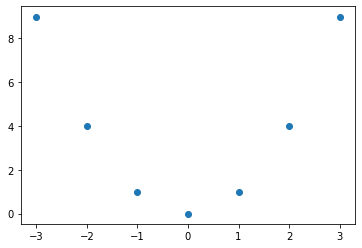

In [55]:
plt.scatter(x_range, vals)

In [68]:
temp = x_range[x_range <= 0]

temp

array([-3., -2., -1.,  0.])

# Test Consav functionality

## Interpolation

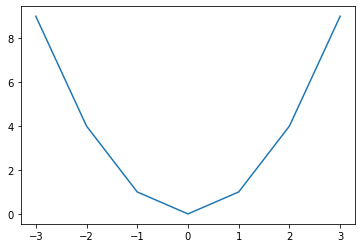

In [31]:
# Plot of the 'raw' function
plt.plot(x_range, vals)

In [38]:
# Define function to be interpolated
interp_func = interpolate.interp1d(x_range, obj_func(x_range))

# Interpolate a finer grid
interp_grid = np.linspace(-3.0,3.0,50)
interp_vals = interp_func(interp_grid)



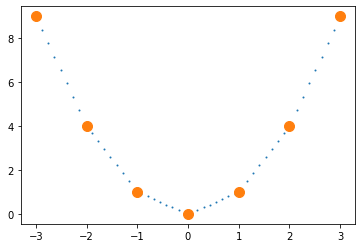

In [49]:
plt.scatter(interp_grid, interp_vals, s=1)
plt.scatter(x_range,obj_func(x_range), s = 100)

## Nonlinspace

In [24]:
Nn = 10 # number of house sizes (change later)
n_min = 0.0 # smalles house
n_max = 3.0 # largest house

n_grid = nonlinspace(n_min,n_max, Nn, 1.5)

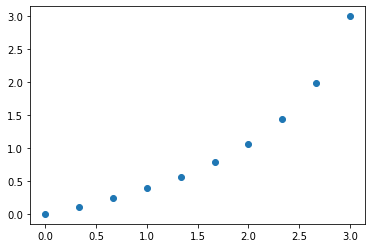

In [25]:
plt.scatter(np.linspace(n_min,n_max,Nn), n_grid)
plt.show()

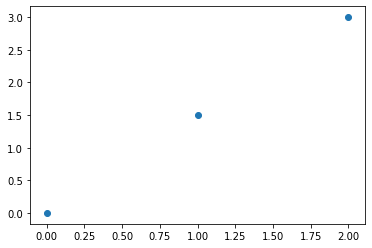

In [74]:
plt.scatter([0,1,2],n_grid)

In [3]:
min_h = 1e-2
max_h = 3.0
Nh = 5

h_grid = np.linspace(min_h, max_h, Nh)

In [4]:
print(h_grid)

[0.01   0.7575 1.505  2.2525 3.    ]


In [51]:
m = 10 - h_grid
m

array([9.99  , 9.2425, 8.495 , 7.7475, 7.    ])

Check interpolation here

In [85]:
x = np.linspace(0,1,10)
y = np.where(x <= 0.5)
# y = x[x<=0.5]
print(y)
# y[1] = 4

(array([0, 1, 2, 3, 4], dtype=int64),)


In [27]:
# Generate transition matrix
p_12 = 1/3
p_21 = 1/3
P = np.array([[1-p_12,p_12],[p_21,1-p_21]])

print(P)
P[0] # First index is the row

[[0.66666667 0.33333333]
 [0.33333333 0.66666667]]


array([0.66666667, 0.33333333])

In [40]:
p_12 = 0.33 # Transition probability
p_21 = 0.33
p_mat = np.array([  # Stochastic matrix for income
    [1-p_12, p_12], 
    [p_21, 1-p_21]])
print(p_mat)

p_mat[0][0]


[[0.67 0.33]
 [0.33 0.67]]


0.6699999999999999

Simulate a Markov chain with $p_{11} = 2/3$ and $p_{22} = 2/3$. So
$$ 
\begin{pmatrix}
p_{11} & p_{12} \\
p_{21} & p_{22}
\end{pmatrix} =
\begin{pmatrix}
\frac{2}{3} & \frac{1}{3} \\
\frac{1}{3} & \frac{2}{3}
\end{pmatrix}
$$

## Test the consav Markov package

In [29]:
@nb.njit
def simulate(grid,trans_cumsum,ergodic_cumsum,simT,simN,eps_ergodic,eps):
    
    # a. allocate
    y = np.zeros((simT,simN))
    k = np.zeros((simT,simN),dtype=np.int_)
    
    # b. simulate
    for t in range(simT):
        for i in range(simN):
            
            # i. lag
            if t == 0:
                k_lag = markov.choice(eps_ergodic[i],ergodic_cumsum) # Choose initial level from the ergodic distribution
            else:
                k_lag = k[t-1,i]
            
            # ii. update
            k[t,i] = markov.choice(eps[t,i],trans_cumsum[k_lag,:])
            
            # iii. value
            y[t,i] = grid[k[t,i]]
    
    return k,y

In [30]:
def show(grid,trans,ergodic,trans_cumsum,ergodic_cumsum):

    np.random.seed(1917)
    
    simT = 100
    simN = 100_000

    eps_ergodic = np.random.uniform(0,1,size=simN)
    eps = np.random.uniform(0,1,size=(simT,simN))

    k,y = simulate(grid,trans_cumsum,ergodic_cumsum,simT,simN,eps_ergodic,eps)      
    
    print(f'simualated ergodic distribution:')
    for i in range(n):
        print(f' {np.mean(k==i):.3f} [theoretical = {ergodic[i]:.3f}]')
    
    return k,y

In [72]:
mu = 0.01
sigma = 0.1
rho = 0.98
n = 21

In [73]:
grid,trans,ergodic,trans_cumsum,ergodic_cumsum = markov.tauchen(mu=mu,sigma=sigma,rho=rho,n=n)

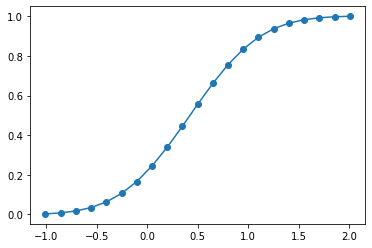

In [88]:
plt.plot(grid,ergodic_cumsum)
plt.scatter(grid,ergodic_cumsum)
plt.show()

In [33]:
k,y = show(grid,trans,ergodic,trans_cumsum,ergodic_cumsum)

simualated ergodic distribution:
 0.003 [theoretical = 0.003]
 0.005 [theoretical = 0.005]
 0.010 [theoretical = 0.010]
 0.017 [theoretical = 0.017]
 0.028 [theoretical = 0.028]
 0.043 [theoretical = 0.043]
 0.060 [theoretical = 0.060]
 0.078 [theoretical = 0.078]
 0.095 [theoretical = 0.095]
 0.106 [theoretical = 0.106]
 0.110 [theoretical = 0.110]
 0.106 [theoretical = 0.106]
 0.095 [theoretical = 0.095]
 0.078 [theoretical = 0.078]
 0.060 [theoretical = 0.060]
 0.043 [theoretical = 0.043]
 0.028 [theoretical = 0.028]
 0.017 [theoretical = 0.017]
 0.010 [theoretical = 0.010]
 0.005 [theoretical = 0.005]
 0.003 [theoretical = 0.003]


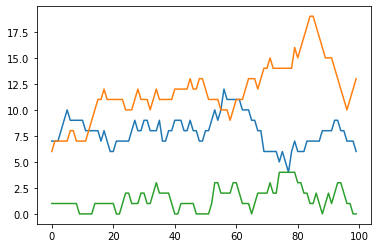

In [163]:
plt.plot(k[:,0:3])

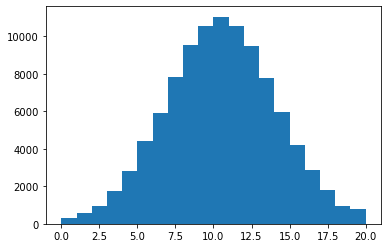

In [194]:
plt.hist(k[1,:], bins = 20)
plt.show()

In [156]:
rand = np.random.uniform()
cs_vec = np.array([1/3,2/3,3/3])

ind = markov.choice(rand,cs_vec)
print(rand)
print(ind)

0.44297394345743835
1


Attempt to simiulate the Markov process

In [196]:
# Set parameters
T = 100
N = 100

p11 = 2/3
p22 = 2/3
p12 = 1 - p11
p21 = 1 - p22

# Transition matrix
P = np.array([[p11, p12],
              [p21, p22]])

P_cum = np.array([np.cumsum(P[i,:]) for i in range(2)])

# Stationary distribution
pi = np.array([1/2,1/2])

pi_cum = np.array(np.cumsum(pi))

# Container for individual states
s = np.zeros((N,T),dtype=np.int_)

# Shocks
rand = np.random.uniform(size=(N,T))

In [183]:
# Simulate path

for t in range(T):
    for n in range(N):
        
        # Initial period, draw from stationary distribution
        if t == 0:
            s_lag = markov.choice(rand[n,t],pi_cum)
        else:
            s_lag = s[n,t-1]
            
        # New state
        s[n,t] = markov.choice(rand[n,t],P_cum[s_lag,:])
        

In [218]:
vec = np.array([1.0, 2.0, 4.0, 10.0])
draw = np.random.choice(vec)
print(draw)

2.0
